In [1]:
%run Read_Tuolumne_data.ipynb #run cell to load data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: ASO Tuolumne basin machine learning and geostatistics data set
    contains: SWE depth maps from 16 Airborne Snow Observatory lidar scans (2016-2019)  and "static" terrain parameters from the SRTM DEM and the National Land Cover Database
    location: Tuolumne basin (around Hetch Hetch Reservoir), in the Californian Sierra Nevada
    time period: Multiple flights in the snow seasons 2016, 2017, 2018, and 2019
    georeferencing: Pixels/cells are regularly spaced in zone 11S of the UTM projection based on the WGS84 ellipsoid.
    convention: By convention, the first pixel (i.e.: row index i=1, column index j=1) is in the upper left corner of the image.
    dimensions: The image stack "D" (SWE maps) have 3 dimensions [dim1=rows=y_i=northing, dim2=columns=x_j=easting, dim3=t_n=time of flight]
    Ground sampling distance: GSD=100 meters (spatial resolution)
    easting coordinate: The easting p

In [2]:
"""Find pass with maximum snow cover and pass with minimum SWE"""
D_sum = np.zeros(16)
for i in range(16):
    h = D[:,:,i][np.logical_not(np.isnan(D[:,:,i]))]
    D_sum[i] = np.sum(h)

D_max_idx = np.argmax(D_sum)
D_min_idx = np.argmin(D_sum)


In [3]:
"""Multi-layer Perceptron regressor"""
def skl_MLPR(x,x_train,x_test,y_train,lr,epochs,hidden_neurons):
    """random forest regression using sklearn"""
    regr = MLPRegressor(hidden_layer_sizes=(hidden_neurons), activation='logistic', solver='adam', alpha=0.0001, learning_rate='constant', learning_rate_init=lr, max_iter=epochs)
    regr.fit(x_train,y_train)
    y_pred_basin = regr.predict(x)#make prediction for the whole basin
    y_pred_test = regr.predict(x_test)
    y_pred_train = regr.predict(x_train)
    return y_pred_basin,y_pred_test, y_pred_train

In [4]:
#MSE vs. N hidden neurons
def MSE_vs_hidden_neurons(pass_index,hidden_neuron_array):
    X = np.transpose(np.array([svf_clean,z_clean,northness_clean,eastness_clean,slp_clean,cc_clean]))#create matrix of all predicators
    x_train, x_test, y_train, y_test = train_test_split(X,D_clean[:,pass_index],test_size=0.8)
    #pass index = ASO flight you wish to run
    lr = 10e-4#learning rate
    epochs = 200
    hidden_neuron_array = np.arange(10,200,10)
    MSE_basin = np.zeros(len(hidden_neuron_array))
    MSE_test = np.zeros(len(hidden_neuron_array))
    MSE_train = np.zeros(len(hidden_neuron_array))
    for i in range(len(hidden_neuron_array)):
        print(i)
        ypred_basin, ypred_test,ypred_train = skl_MLPR(X,x_train,x_test,y_train,lr,epochs,hidden_neuron_array[i])
        MSE_basin[i] = metric.mean_squared_error(D_clean[:,pass_index],ypred_basin)
        MSE_train[i] = metric.mean_squared_error(y_train,ypred_train)
        MSE_test[i] = metric.mean_squared_error(y_test,ypred_test)
    return ypred_basin,ypred_test,ypred_train,MSE_basin,MSE_train,MSE_test,y_test

hidden_neurons = np.arange(10,200,10)
#hidden_neurons = np.arange(1,40)

y_basin_neuron_max,y_test_neuron_max,y_train_neuron_max,MSE_basin_neuron_max,MSE_train_neuron_max,MSE_test_neuron_max,y_test_max = MSE_vs_hidden_neurons(D_max_idx,hidden_neurons)
y_basin_neuron_min,y_test_neuron_min,y_train_neuron_min,MSE_basin_neuron_min,MSE_train_neuron_min,MSE_test_neuron_min,y_test_min = MSE_vs_hidden_neurons(D_min_idx,hidden_neurons)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [5]:
"""Save files for posterity"""

"""np.savetxt('test_runs/' + 'y_pred_basin_neurons_max.txt', y_basin_neuron_max)
np.savetxt('test_runs/' + 'y_pred_test_neurons_max.txt', y_test_neuron_max)
np.savetxt('test_runs/' + 'y_pred_basin_neurons_min.txt', y_basin_neuron_min)
np.savetxt('test_runs/' + 'y_pred_test_neurons_min.txt', y_test_neuron_min)
np.savetxt('test_runs/' + 'y_test_neurons_max.txt',y_test_max)
np.savetxt('test_runs/' + 'y_test_neurons_min.txt',y_test_min)"""


"np.savetxt('test_runs/' + 'y_pred_basin_neurons_max.txt', y_basin_neuron_max)\nnp.savetxt('test_runs/' + 'y_pred_test_neurons_max.txt', y_test_neuron_max)\nnp.savetxt('test_runs/' + 'y_pred_basin_neurons_min.txt', y_basin_neuron_min)\nnp.savetxt('test_runs/' + 'y_pred_test_neurons_min.txt', y_test_neuron_min)\nnp.savetxt('test_runs/' + 'y_test_neurons_max.txt',y_test_max)\nnp.savetxt('test_runs/' + 'y_test_neurons_min.txt',y_test_min)"

No handles with labels found to put in legend.


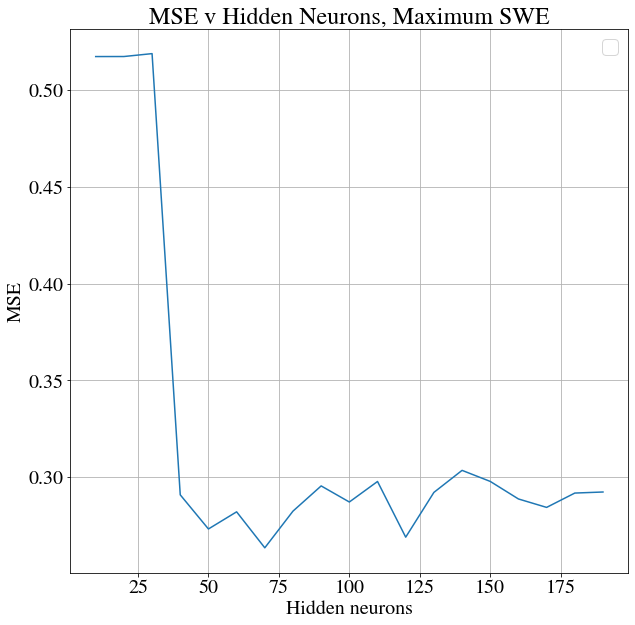

No handles with labels found to put in legend.


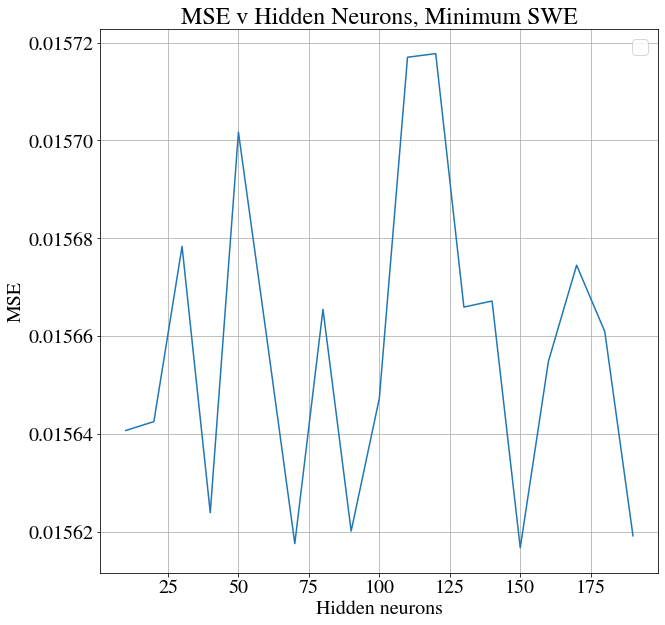

In [6]:
#plot MSE vs. N hidden neurons
hidden_neuron_array = np.arange(10,200,10)
plt.rcParams['font.size'] = 20
plt.figure(figsize = [10,10])
plt.plot(hidden_neuron_array,MSE_test_neuron_max)
plt.xlabel('Hidden neurons')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.title('MSE v Hidden Neurons, Maximum SWE')
plt.savefig('figs/MSEvsNeurons_max.png')
plt.show()

plt.rcParams['font.size'] = 20
plt.figure(figsize = [10,10])
plt.plot(hidden_neuron_array,MSE_test_neuron_min)
plt.xlabel('Hidden neurons')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.title('MSE v Hidden Neurons, Minimum SWE')
plt.savefig('figs/MSEvsNeurons_min.png')
plt.show()


In [7]:
#MSE vs. Learning rate
def MSE_vs_Learning_Rate(pass_index):
    X = np.transpose(np.array([svf_clean,z_clean,northness_clean,eastness_clean,slp_clean,cc_clean]))#create matrix of all predicators
    x_train, x_test, y_train, y_test = train_test_split(X,D_clean[:,pass_index],test_size=0.8)
    
    learning_r = np.logspace(-7,0,50)#array of differnt learning rates to test
    epochs = 200
    n_hidden_neuron = 60
    MSE_basin = np.zeros(len(learning_r))
    MSE_test = np.zeros(len(learning_r))
    MSE_train = np.zeros(len(learning_r))

    for i in range(len(learning_r)):#test for every learning rate
        print(i)
        ypred_basin, ypred_test,ypred_train = skl_MLPR(X,x_train,x_test,y_train,learning_r[i],epochs,n_hidden_neuron)
        MSE_basin[i] = metric.mean_squared_error(D_clean[:,pass_index],ypred_basin)
        MSE_train[i] = metric.mean_squared_error(y_train,ypred_train)
        MSE_test[i] = metric.mean_squared_error(y_test,ypred_test)
    return ypred_basin,ypred_test,ypred_train,MSE_basin,MSE_train,MSE_test,learning_r,y_test

y_basin_lr_max,y_test_lr_max,y_train_lr_max,MSE_basin_lr_max,MSE_train_lr_max,MSE_test_lr_max,learning_rate,y_test_max = MSE_vs_Learning_Rate(D_max_idx)
y_basin_lr_min,y_test_lr_min,y_train_lr_min,MSE_basin_lr_min,MSE_train_lr_min,MSE_test_lr_min,learning_rate,y_test_min = MSE_vs_Learning_Rate(D_min_idx)

0


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


6


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7
8
9


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


10


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


11


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


12
13


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


14


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


15


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


16


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


17
18
19
20
21
22


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


23


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


24
25


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


26


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


No handles with labels found to put in legend.
No handles with labels found to put in legend.


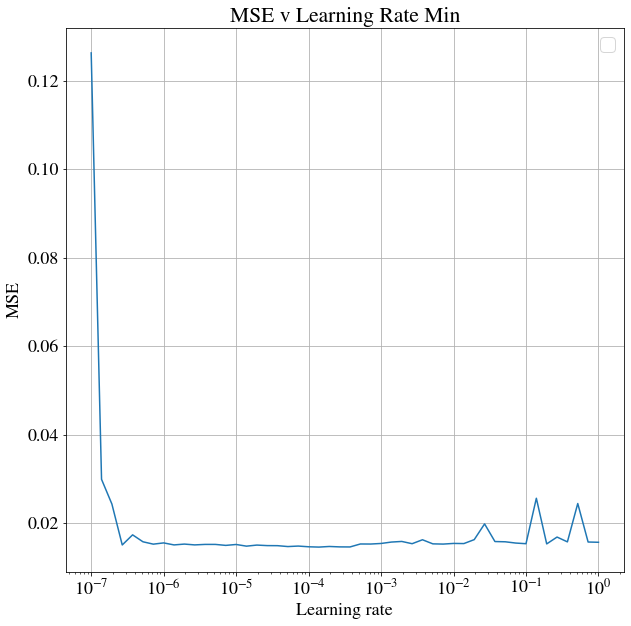

No handles with labels found to put in legend.
No handles with labels found to put in legend.


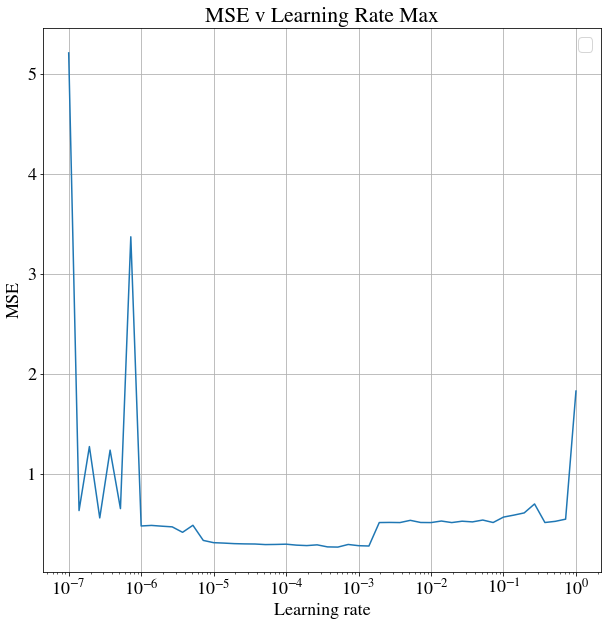

In [8]:
plt.rcParams['font.size'] = 18
plt.figure(figsize = [10,10])
plt.plot(learning_rate,MSE_test_lr_min)
plt.xlabel('Learning rate')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE v Learning Rate Min')
plt.grid(); plt.legend(); plt.semilogx()
plt.savefig('figs/MSEvslearning_rate_min.png')
plt.show()

plt.rcParams['font.size'] = 18
plt.figure(figsize = [10,10])
plt.plot(learning_rate,MSE_test_lr_max)
plt.xlabel('Learning rate')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE v Learning Rate Max')
plt.grid(); plt.legend(); plt.semilogx()
plt.savefig('figs/MSEvslearning_rate_max.png')
plt.show()

In [9]:
def MSE_vs_Epochs(pass_idx):
    X = np.transpose(np.array([svf_clean,z_clean,northness_clean,eastness_clean,slp_clean,cc_clean]))#create matrix of all predicators
    x_train, x_test, y_train, y_test = train_test_split(X,D_clean[:,pass_idx],test_size=0.8)
    #MSE vs. Learning rate
    lr = 1e-4#learning rate
    epochs = np.arange(50,1000,50)
    n_hidden_neuron = 60
    MSE_basin = np.zeros(len(epochs))
    MSE_test = np.zeros(len(epochs))
    MSE_train = np.zeros(len(epochs))

    for i in range(len(epochs)):
        print(i)
        ypred_basin, ypred_test,ypred_train = skl_MLPR(X,x_train,x_test,y_train,lr,epochs[i],n_hidden_neuron)
        MSE_basin[i] = metric.mean_squared_error(D_clean[:,pass_idx],ypred_basin)
        MSE_train[i] = metric.mean_squared_error(y_train,ypred_train)
        MSE_test[i] = metric.mean_squared_error(y_test,ypred_test)
    

    return ypred_basin,ypred_test,ypred_train,MSE_basin,MSE_train,MSE_test,epochs,y_test

y_basin_ep_max,y_test_ep_max,y_train_ep_max,MSE_basin_ep_max,MSE_train_ep_max,MSE_test_ep_max,epochs,y_test_max = MSE_vs_Epochs(D_max_idx)
y_basin_ep_min,y_test_ep_min,y_train_ep_min,MSE_basin_ep_min,MSE_train_ep_min,MSE_test_ep_min,epochs,y_test_min = MSE_vs_Epochs(D_min_idx)

0


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


/Users/georgestanleycowie/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


No handles with labels found to put in legend.
No handles with labels found to put in legend.


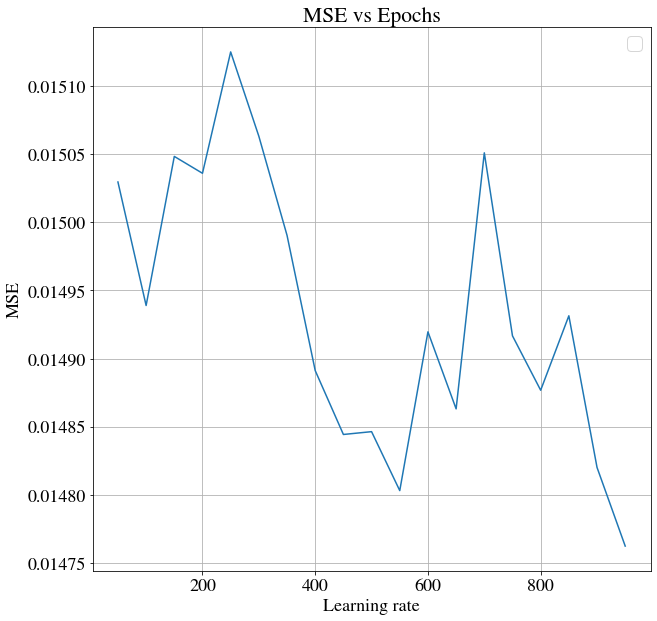

No handles with labels found to put in legend.
No handles with labels found to put in legend.


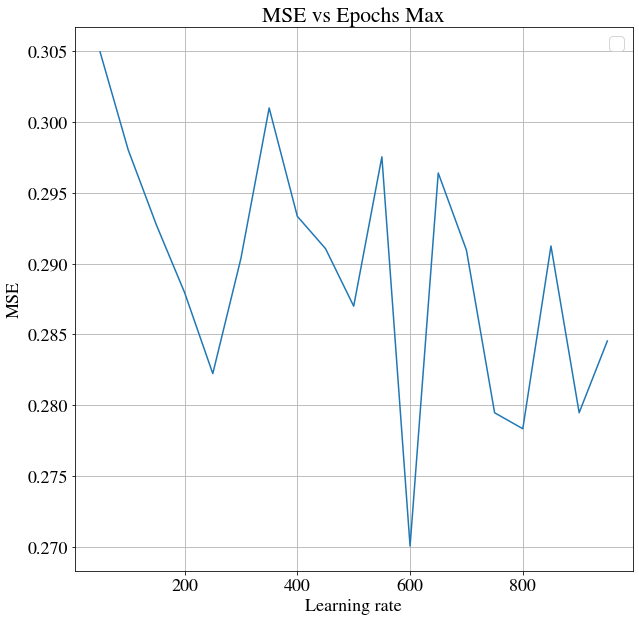

In [10]:
plt.rcParams['font.size'] = 18
plt.figure(figsize = [10,10])
plt.plot(epochs,MSE_test_ep_min)
plt.xlabel('Learning rate')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Epochs')
plt.grid(); plt.legend();
plt.savefig('figs/MSEvsepochs_min.png')
plt.show()

plt.rcParams['font.size'] = 18
plt.figure(figsize = [10,10])
plt.plot(epochs,MSE_test_ep_max)
plt.xlabel('Learning rate')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Epochs Max')
plt.grid(); plt.legend();
plt.savefig('figs/MSEvsepochs_max.png')
plt.show()

In [11]:
"""Run the algorithm for all ASO passes with optimized hyperparameters"""
X = np.transpose(np.array([svf_clean,z_clean,northness_clean,eastness_clean,slp_clean,cc_clean]))#create matrix of all predicators
x_train, x_test, y_train, y_test = train_test_split(X,D_clean,test_size=0.8)
Epochs = 250
Learning_rate = 1e-4
Hidden_neurons = 60
MSE_basin = np.zeros(16)
MSE_test = np.zeros(16)
MSE_train = np.zeros(16)

y_test_predictions = np.zeros(y_test.shape)
y_train_predictions = np.zeros(y_train.shape)
y_basin_predictions = np.zeros(D_clean.shape)
R2_test = np.zeros(16)
print(x_train.shape)
for i in range(16):
    print(i)
    ypred_basin,ypred_test,ypred_train = skl_MLPR(X,x_train,x_test,y_train[:,i],Learning_rate,Epochs,Hidden_neurons)
    MSE_basin[i] = metric.mean_squared_error(D_clean[:,i],ypred_basin)
    MSE_train[i] = metric.mean_squared_error(y_train[:,i],ypred_train)
    MSE_test[i] = metric.mean_squared_error(y_test[:,i],ypred_test)

    R2_test[i] = metric.r2_score(y_test[:,i],ypred_test)
    y_test_predictions[:,i] = ypred_test
    y_train_predictions[:,i] =  ypred_train
    y_basin_predictions[:,i] = ypred_basin


#Create arrays to save MSE ans y_pred for each pass

#ypred_basin, ypred_test,ypred_train = skl_MLPR(X,x_train,x_test,y_train,learning_r[i],epochs,n_hidden_neuron)

(32158, 6)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [12]:
"""Save files"""
"""np.savetxt('test_runs/' + 'y_test_predict_NN.txt', y_test_predictions)
np.savetxt('test_runs/' + 'y_basin_predict_NN.txt', y_basin_predictions)
np.savetxt('test_runs/' + 'y_test_NN.txt', y_test)"""

"np.savetxt('test_runs/' + 'y_test_predict_NN.txt', y_test_predictions)\nnp.savetxt('test_runs/' + 'y_basin_predict_NN.txt', y_basin_predictions)\nnp.savetxt('test_runs/' + 'y_test_NN.txt', y_test)"

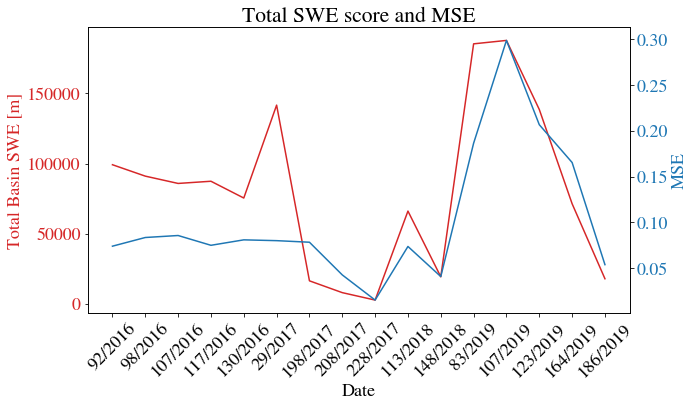

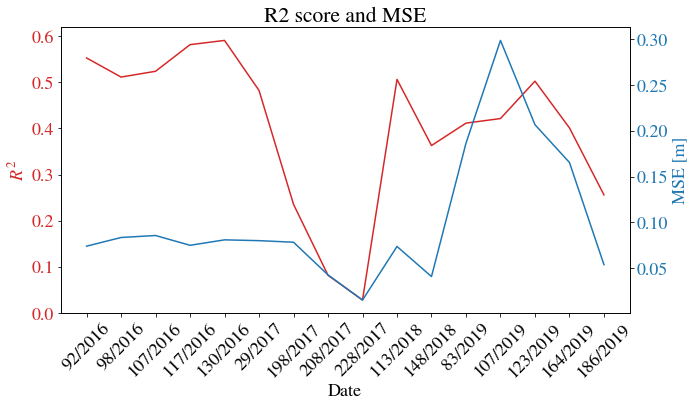

In [13]:
date = [] 
for i in range(16):
    date.append(np.str(DOY[i]) + '/' + np.str(year[i]))

    plt.rcParams['font.size'] = 18
plt.figure(figsize=(10,6))
color = 'tab:red'
plt.xlabel('Date')
plt.ylabel('Total Basin SWE [m]', color=color)
plt.plot(D_sum, color=color)
plt.tick_params(axis='y', labelcolor=color)
plt.xticks( np.arange(16), date ,rotation = 45)
plt.title('Total SWE score and MSE')
ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MSE', color=color)  # we already handled the x-label with ax1
ax2.plot( MSE_test, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('figs/MSE_totSWE_NN.png')
plt.show()

plt.rcParams['font.size'] = 18
plt.figure(figsize=(10,6))
color = 'tab:red'
plt.xlabel('Date')
plt.ylabel('$R^2$', color=color)
plt.plot(R2_test, color=color)
plt.tick_params(axis='y', labelcolor=color)
plt.xticks( np.arange(16), date ,rotation = 45)
plt.title('R2 score and MSE')
ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('MSE [m]', color=color)  # we already handled the x-label with ax1
ax2.plot( MSE_test, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('figs/R2_MSE_NN.png')
plt.show()

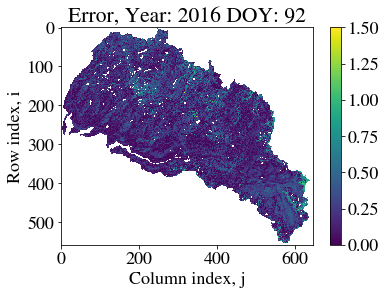

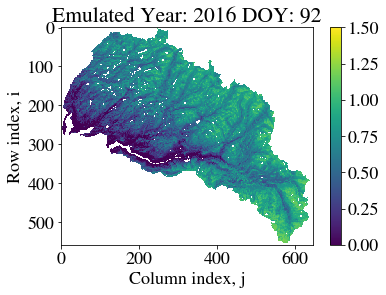

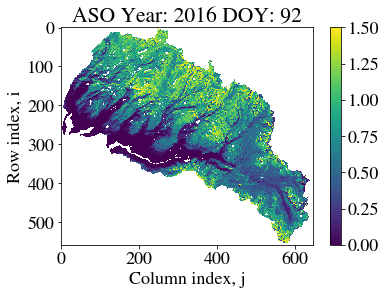

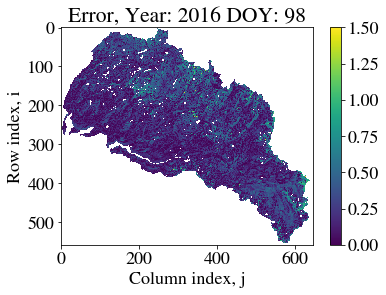

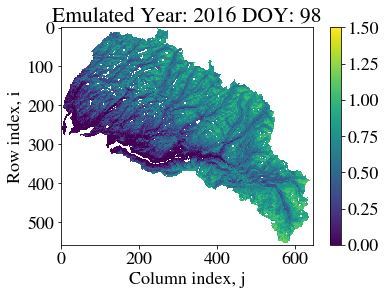

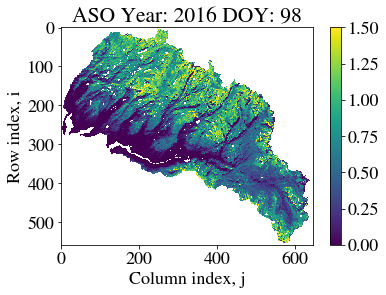

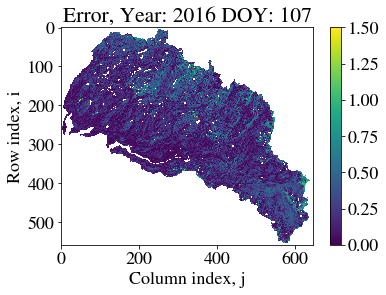

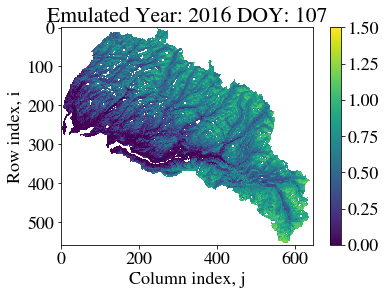

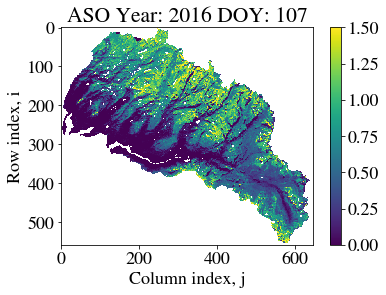

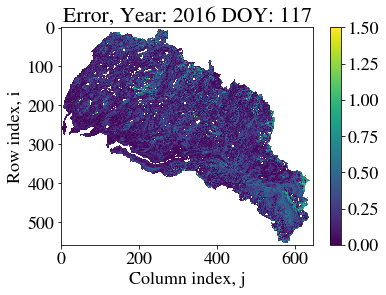

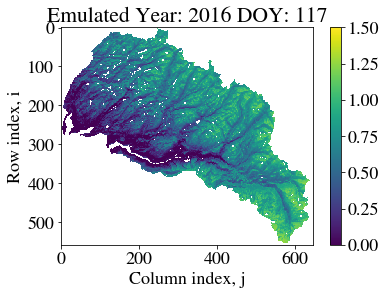

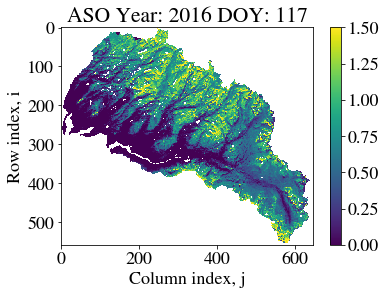

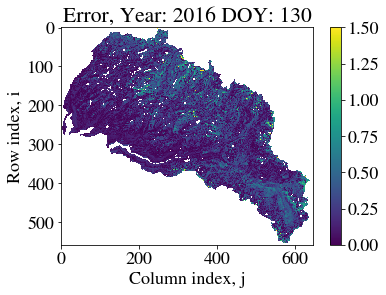

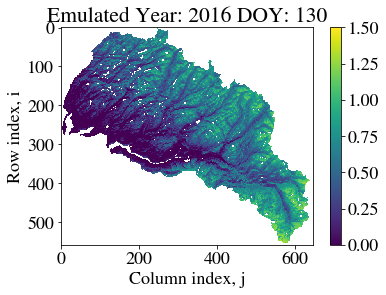

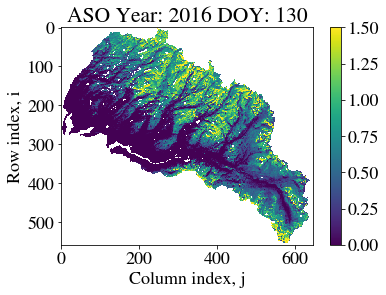

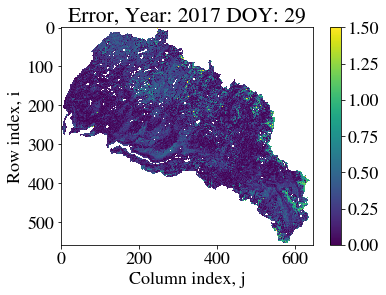

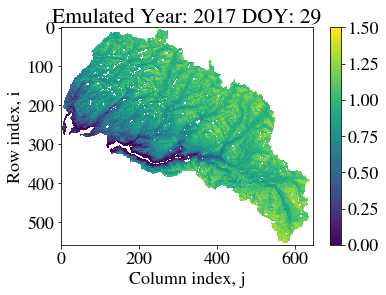

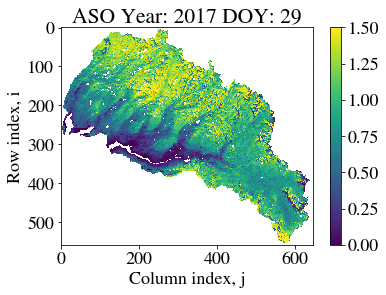

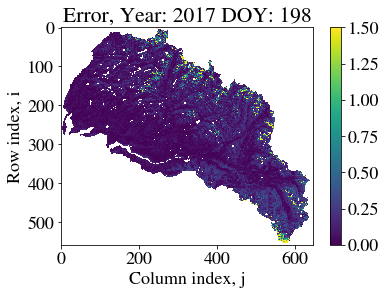

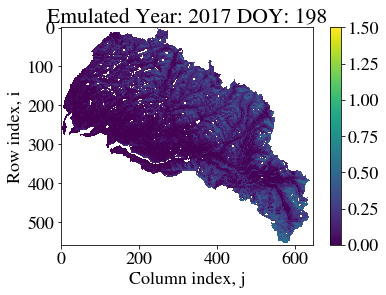

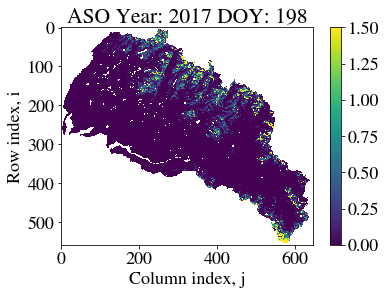

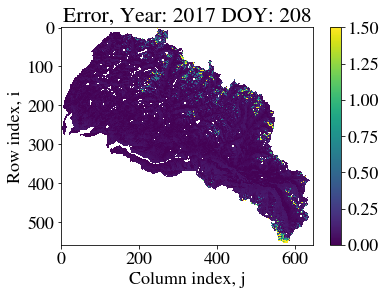

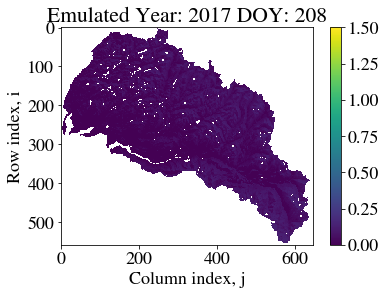

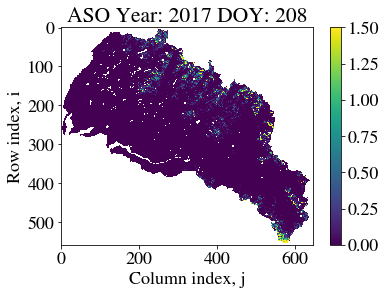

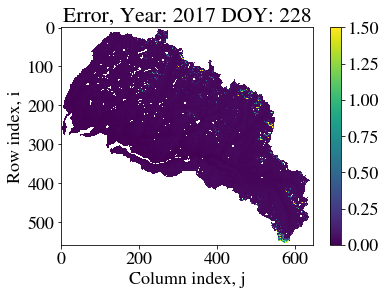

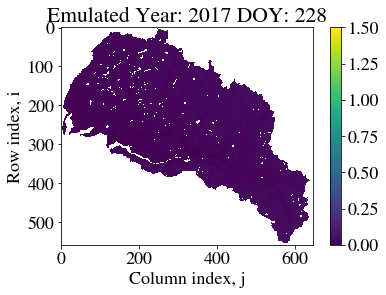

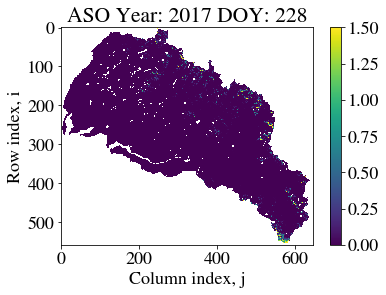

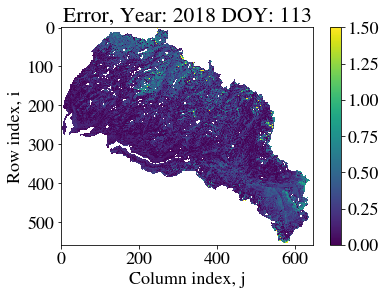

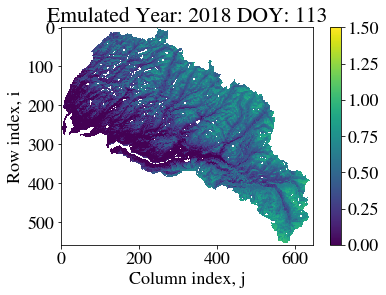

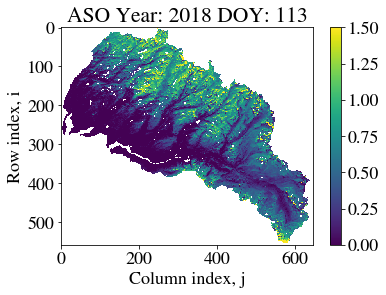

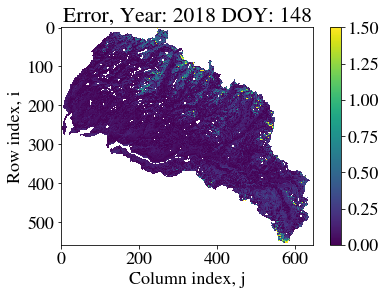

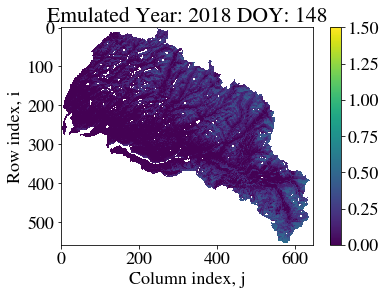

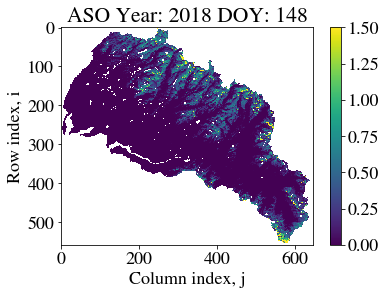

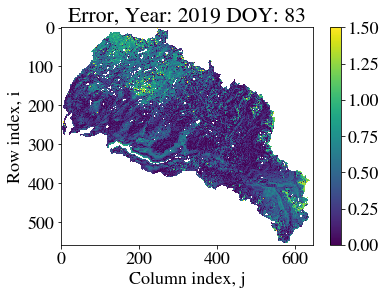

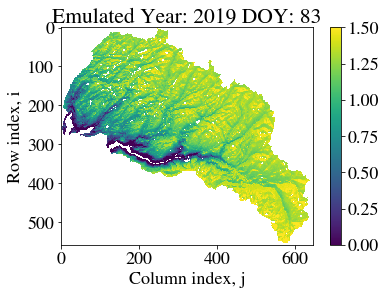

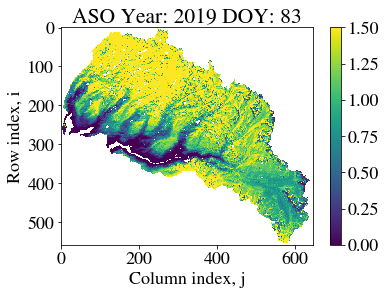

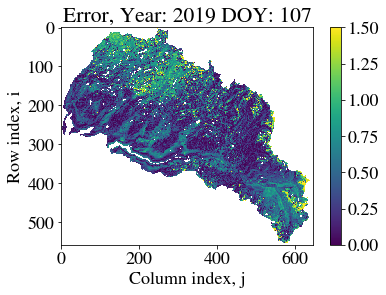

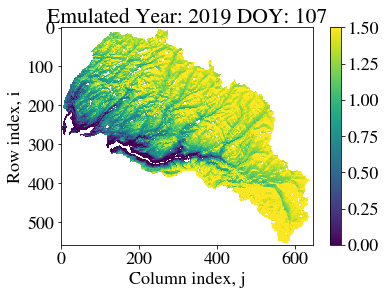

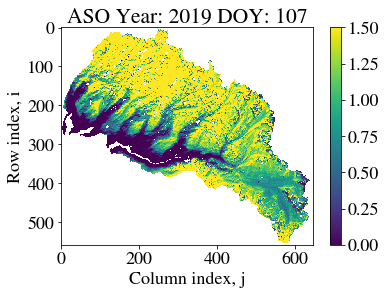

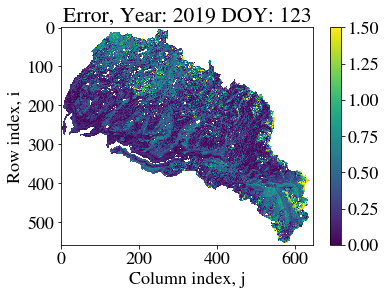

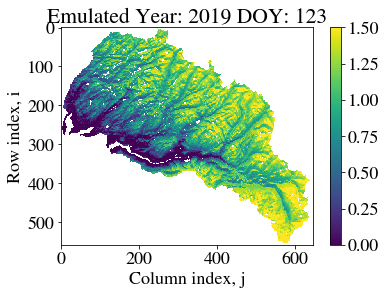

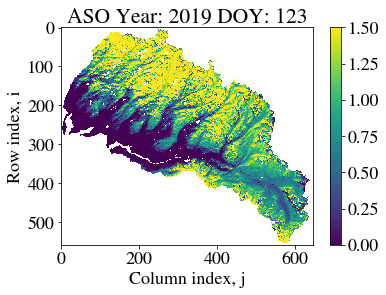

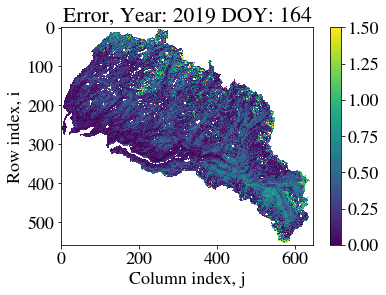

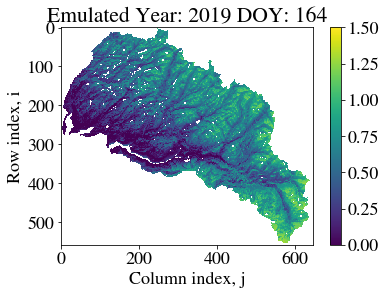

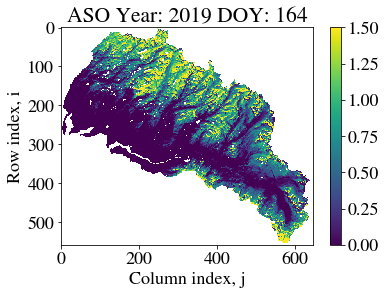

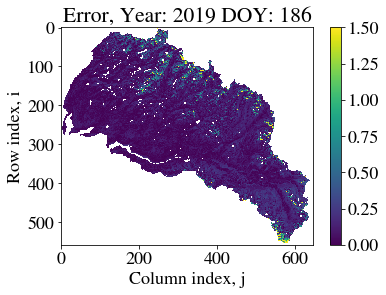

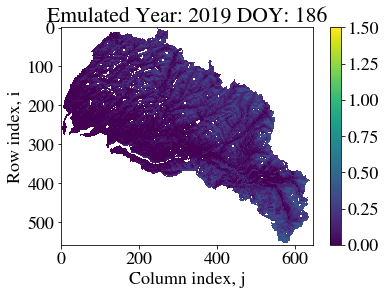

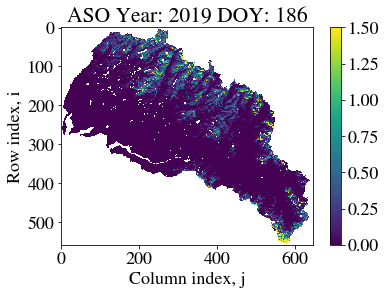

In [15]:
#Map back to coordinates for visualization
D_pred=np.zeros_like(D)
for i in range(D.shape[2]):
    D_pred[not_nan,i]=y_basin_predictions[:,i]
    D_pred[~not_nan,i]=np.nan
    
    plt.figure()
    cm=plt.imshow((np.abs(D_pred[:,:,i]-D[:,:,i])))
    plt.title('Error, Year: '+str(year[i])+' DOY: ' + str(DOY[i]))
    plt.ylabel('Row index, i')
    plt.xlabel('Column index, j')
    plt.clim(0, 1.5)
    plt.colorbar()
    plt.show()
    
    
    cm=plt.imshow((D_pred[:,:,i]))
    plt.title('Emulated Year: '+str(year[i])+' DOY: ' + str(DOY[i]))
    plt.ylabel('Row index, i')
    plt.xlabel('Column index, j')
    plt.clim(0, 1.5)
    plt.colorbar()
    plt.show()

    cm=plt.imshow((D[:,:,i]))
    plt.title('ASO Year: '+str(year[i])+' DOY: ' + str(DOY[i]))
    plt.ylabel('Row index, i')
    plt.xlabel('Column index, j')
    plt.clim(0, 1.5)
    plt.colorbar()
    plt.show()
    #plt.close('all')

In [ ]:
#Map back to coordinates for visualization
import matplotlib as mpl
def visual_map(i,save_or_not):
    D_pred=np.zeros_like(D)
    D_pred[not_nan,i]=y_basin_predictions[:,i]
    D_pred[~not_nan,i]=np.nan
    
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5, .5, .5, 1.0)
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = np.linspace(0, 0.8, 14)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    plt.figure()
    cm=plt.imshow((np.abs(D_pred[:,:,i]-D[:,:,i])),cmap=cmap,norm = norm)
    plt.title('Error, Year: '+str(year[i])+' DOY: ' + str(DOY[i]))
    plt.ylabel('Row index, i')
    plt.xlabel('Column index, j')
    plt.clim(0, 0.7)
    plt.colorbar()
    if save_or_not == True:
        (print('Image saved'))
        plt.savefig('NN_Map_error' +str(year[i])+'_DOY_' + str(DOY[i])+'.png')
    plt.show()
    
    
    cm=plt.imshow((D_pred[:,:,i]))
    plt.title('Emulated Year: '+str(year[i])+' DOY: ' + str(DOY[i]))
    plt.ylabel('Row index, i')
    plt.xlabel('Column index, j')
    plt.clim(0, 1.5)
    plt.colorbar()
    if save_or_not == True:
        (print('Image saved'))
        plt.savefig('NN_Map_emulated' +str(year[i])+'_DOY_' + str(DOY[i])+'.png')
    plt.show()

    cm=plt.imshow((D[:,:,i]))
    plt.title('ASO Year: '+str(year[i])+' DOY: ' + str(DOY[i]))
    plt.ylabel('Row index, i')
    plt.xlabel('Column index, j')
    plt.clim(0, 1.5)
    plt.colorbar()
    if save_or_not == True:
        (print('Image saved'))
        plt.savefig('NN_Map_true' +str(year[i])+'_DOY_' + str(DOY[i])+'.png')
    plt.show()

for i in range(D.shape[2]):
    visual_map(i,False)

plt.close('all')

In [ ]:
"""Save selected runs for report"""
#12 107/2019
#3 117/2016
#8 208/2017
visual_map(12,True)
visual_map(3,True)
visual_map(10,True)